### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-colorblind")

In [3]:
CSV_PATH = "../original_data/clean_data.csv"
LOAD_COL = "day_ahead_load_forecast"

df = pd.read_csv(CSV_PATH, parse_dates=[0])
df = df.rename(columns={df.columns[0]: "dt"}).set_index("dt").sort_index()

df["hour"] = df.index.hour
df["weekday"] = df.index.weekday  # Monday=0
df["is_weekend"] = df["weekday"] >= 5
df["year"] = df.index.year
df["month_period"] = df.index.to_period("M")

### Helpers

In [40]:
def _qstats(s: pd.Series, prefix: str) -> pd.Series:
    q = s.quantile([0.25, 0.5, 0.75])
    return pd.Series({
        f"{prefix}_q25": float(q.loc[0.25]),
        f"{prefix}_median": float(q.loc[0.5]),
        f"{prefix}_q75": float(q.loc[0.75]),
    })

def month_metrics(g: pd.DataFrame) -> pd.Series:
    out = {}

    for label, mask in [("weekday", ~g["is_weekend"]), ("weekend", g["is_weekend"])]:
        sub = g.loc[mask]
        if sub.empty:
            out.update({
                f"morning_ramp_0408_{label}_q25": np.nan,
                f"morning_ramp_0408_{label}_median": np.nan,
                f"morning_ramp_0408_{label}_q75": np.nan,
                f"evening_minus_midday_{label}_q25": np.nan,
                f"evening_minus_midday_{label}_median": np.nan,
                f"evening_minus_midday_{label}_q75": np.nan,
                f"peak_hour_{label}_q25": np.nan,
                f"peak_hour_{label}_median": np.nan,
                f"peak_hour_{label}_q75": np.nan,
            })
            continue

        tmp = sub.copy()
        tmp["date"] = tmp.index.date
        tbl = (
            tmp.pivot_table(index="date", columns="hour", values=LOAD_COL, aggfunc="mean")
               .reindex(columns=range(24))
        )

        morning_ramp = tbl[8] - tbl[4]
        midday_mean = tbl[[11, 12, 13, 14]].mean(axis=1)
        evening_peak = tbl[[16, 17, 18, 19, 20]].max(axis=1)
        evening_minus_midday = evening_peak - midday_mean
        peak_hour = tbl.idxmax(axis=1).astype(int)

        out.update(_qstats(morning_ramp, f"morning_ramp_0408_{label}").to_dict())
        out.update(_qstats(evening_minus_midday, f"evening_minus_midday_{label}").to_dict())
        out.update(_qstats(peak_hour, f"peak_hour_{label}").to_dict())

    return pd.Series(out)

monthly_metrics = (
    df.groupby("month_period", sort=True)
      .apply(month_metrics)
      .reset_index()
)

monthly_metrics["month_start"] = monthly_metrics["month_period"].dt.to_timestamp()
monthly_metrics["year"] = monthly_metrics["month_start"].dt.year
monthly_metrics["month_num"] = monthly_metrics["month_start"].dt.month

def derivative_iqr_by_year(df, day_mask, order=1):
    sub = df.loc[day_mask].copy()
    sub["date"] = sub.index.date
    out = {}

    for y, g in sub.groupby("year"):
        tbl = (
            g.pivot_table(index="date", columns="hour", values=LOAD_COL, aggfunc="mean")
             .reindex(columns=range(24))
        ).to_numpy()

        if order == 1:
            der = np.gradient(tbl, axis=1)
        else:
            der = np.gradient(np.gradient(tbl, axis=1), axis=1)

        q25 = np.nanpercentile(der, 25, axis=0)
        med = np.nanpercentile(der, 50, axis=0)
        q75 = np.nanpercentile(der, 75, axis=0)

        out[y] = pd.DataFrame({"q25": q25, "median": med, "q75": q75}, index=range(24))

    return out

/var/folders/8w/zmlxvyj52l7_fdlcpjyc4rd40000gn/T/ipykernel_10101/4176094825.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(month_metrics)


### Duck Curves

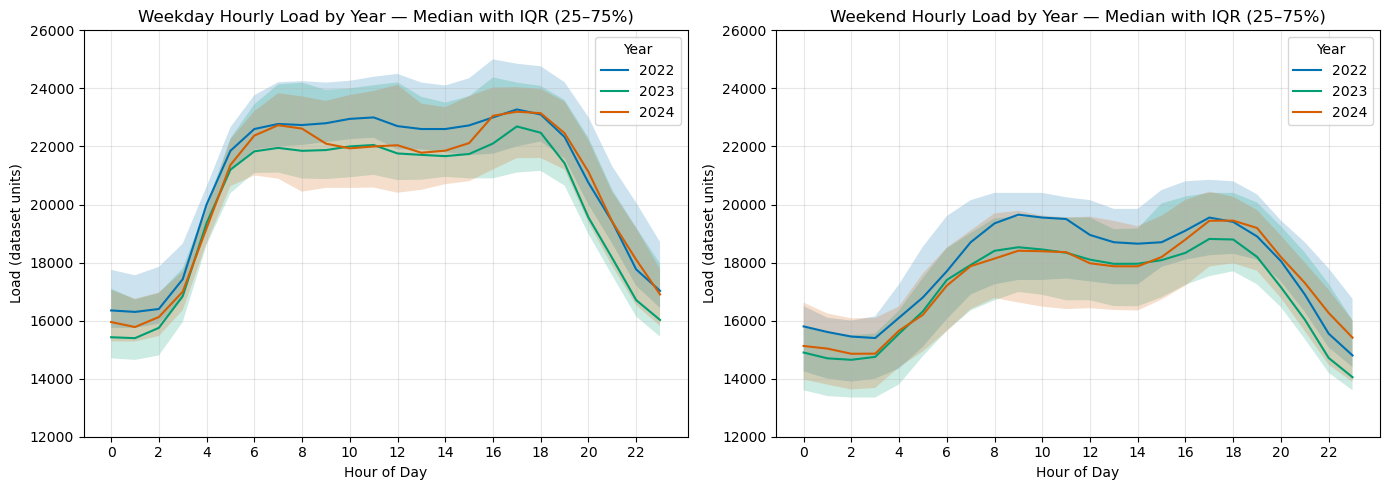

In [ ]:
weekday = df.loc[~df["is_weekend"]]
weekend = df.loc[df["is_weekend"]]

wd_q = (
    weekday.groupby(["year", "hour"])[LOAD_COL]
           .quantile([0.25, 0.5, 0.75])
           .unstack(-1)
           .rename(columns={0.25: "q25", 0.5: "median", 0.75: "q75"})
           .sort_index()
)
we_q = (
    weekend.groupby(["year", "hour"])[LOAD_COL]
           .quantile([0.25, 0.5, 0.75])
           .unstack(-1)
           .rename(columns={0.25: "q25", 0.5: "median", 0.75: "q75"})
           .sort_index()
)

years_wd = sorted(wd_q.index.get_level_values("year").unique())
years_we = sorted(we_q.index.get_level_values("year").unique())
hrs = np.arange(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

ax = axes[0]
for y in years_wd:
    sub = wd_q.loc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Weekday Hourly Load by Year — Median with IQR (25–75%)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (dataset units)")
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.set_ylim(12000,26000)
ax.legend(title="Year")

ax = axes[1]
for y in years_we:
    sub = we_q.loc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Weekend Hourly Load by Year — Median with IQR (25–75%)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (dataset units)")
ax.set_xticks(np.arange(0, 24, 2))
ax.set_ylim(12000,26000)
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

### Duck Curve Velocity

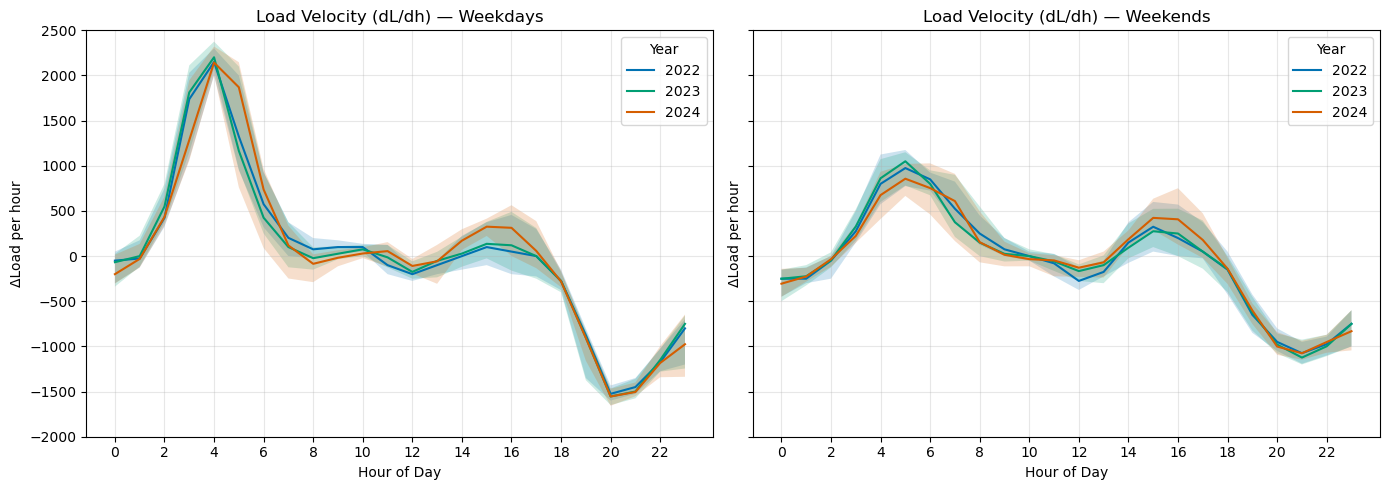

In [41]:
wd_vel = derivative_iqr_by_year(df, ~df["is_weekend"], order=1)
we_vel = derivative_iqr_by_year(df,  df["is_weekend"], order=1)

hrs = np.arange(24)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
for y in sorted(wd_vel.keys()):
    sub = wd_vel[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Velocity (dL/dh) — Weekdays")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("ΔLoad per hour")
ax.set_ylim(-2000, 2500)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(we_vel.keys()):
    sub = we_vel[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Velocity (dL/dh) — Weekends")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("ΔLoad per hour")
ax.set_ylim(-2000, 2500)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

### Duck Curve Acceleration

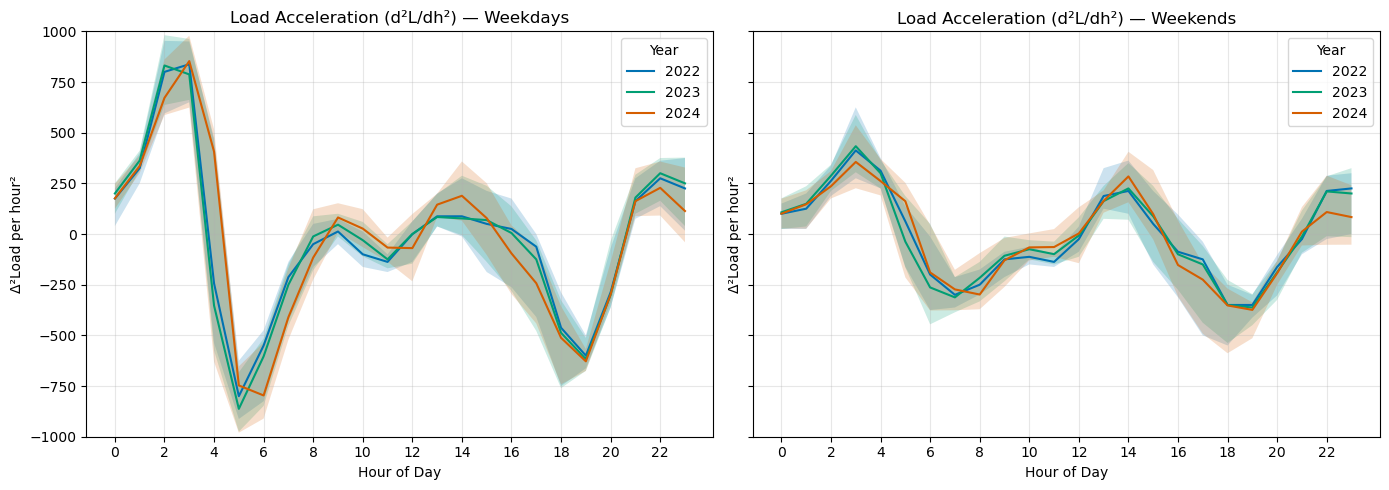

In [42]:
wd_acc = derivative_iqr_by_year(df, ~df["is_weekend"], order=2)
we_acc = derivative_iqr_by_year(df,  df["is_weekend"], order=2)

hrs = np.arange(24)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
for y in sorted(wd_acc.keys()):
    sub = wd_acc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Acceleration (d²L/dh²) — Weekdays")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Δ²Load per hour²")
ax.set_ylim(-1000, 1000)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(we_acc.keys()):
    sub = we_acc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Acceleration (d²L/dh²) — Weekends")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Δ²Load per hour²")
ax.set_ylim(-1000, 1000)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

### Duck Curve Difference High-Low

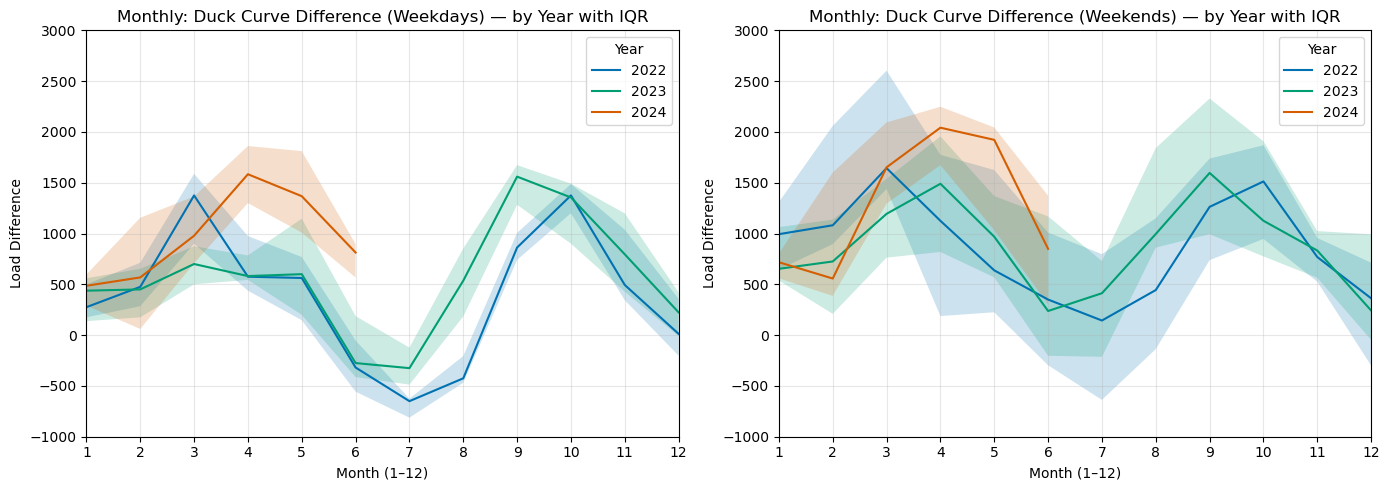

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

ax = axes[0]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["evening_minus_midday_weekday_median"]
    q25 = sub["evening_minus_midday_weekday_q25"]
    q75 = sub["evening_minus_midday_weekday_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Duck Curve Difference (Weekdays) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_ylim(-1000,3000)
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["evening_minus_midday_weekend_median"]
    q25 = sub["evening_minus_midday_weekend_q25"]
    q75 = sub["evening_minus_midday_weekend_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Duck Curve Difference (Weekends) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_ylim(-1000,3000)
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

### Morning Ramps

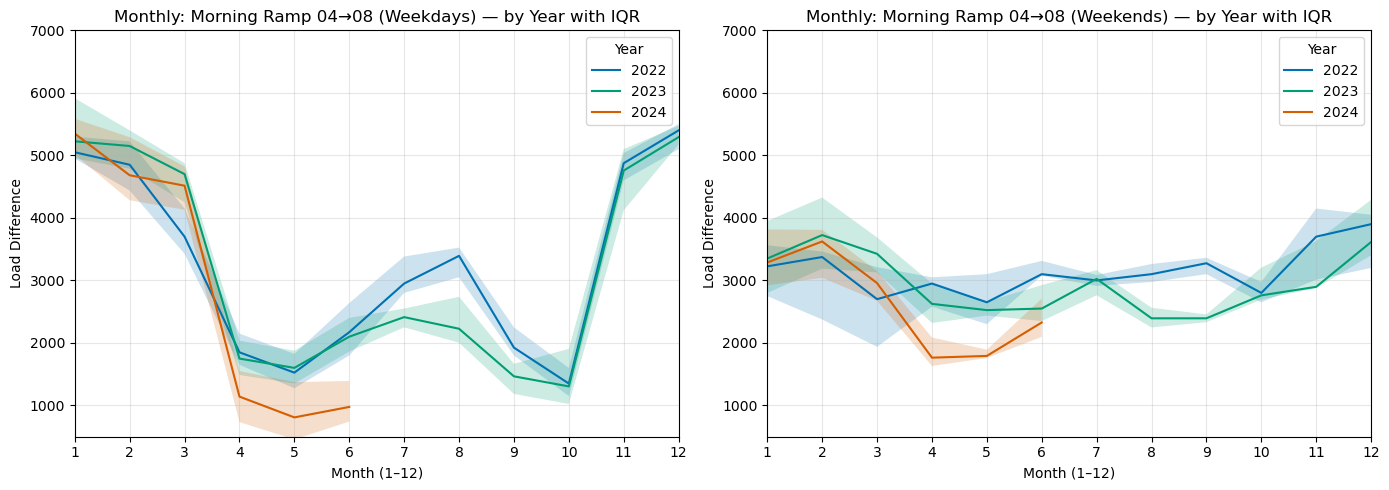

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

ax = axes[0]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["morning_ramp_0408_weekday_median"]
    q25 = sub["morning_ramp_0408_weekday_q25"]
    q75 = sub["morning_ramp_0408_weekday_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Morning Ramp 04→08 (Weekdays) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_ylim(500,7000)
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["morning_ramp_0408_weekend_median"]
    q25 = sub["morning_ramp_0408_weekend_q25"]
    q75 = sub["morning_ramp_0408_weekend_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Morning Ramp 04→08 (Weekends) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_ylim(500,7000)
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()


### Peak Hours of Average Load

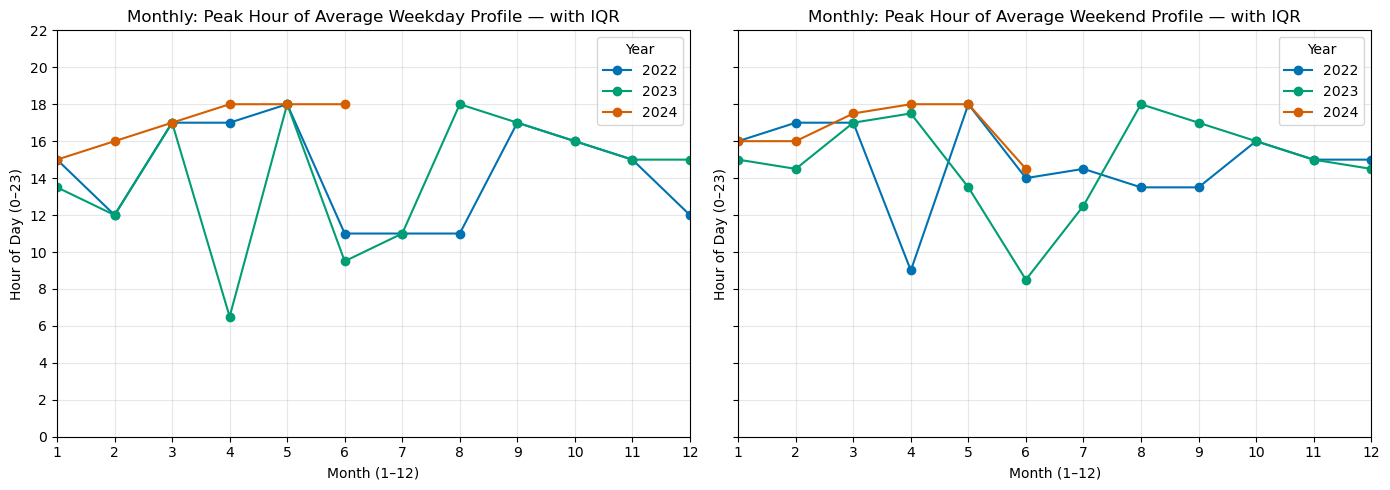

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["peak_hour_weekday_median"]
    ax.plot(x, med, marker="o", linestyle="-", label=str(y))
ax.set_title("Monthly: Peak Hour of Average Weekday Profile — with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Hour of Day (0–23)")
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_yticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["peak_hour_weekend_median"]
    ax.plot(x, med, marker="o", linestyle="-", label=str(y))
ax.set_title("Monthly: Peak Hour of Average Weekend Profile — with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Hour of Day (0–23)")
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_yticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()


### Infere Industrial Sector Load

The (crude) industrial component by comparing weekday load to a weekend baseline at the same month and hour. Specifically, for each month–hour pair we compute the weekend median load to capture seasonality, daylight, and weather effects without workday activity, and then define the weekday excess as the total load minus the median weekend load. 

In [ ]:
# Weekend baseline: median by (month_period, hour)
weekend_baseline = (
    df.loc[df["is_weekend"]]
      .groupby(["month_period", "hour"])[LOAD_COL]
      .median()
      .unstack("hour")
      .reindex(columns=range(24))
      .sort_index()
)

# Attaching baseline to every timestamp by (month_period, hour)
b_stack = (
    weekend_baseline.stack()
    .rename("baseline")
    .reset_index()
    .rename(columns={"level_1": "hour"})
)

tmp = (
    df[["month_period", "hour"]]
    .reset_index()
    .merge(b_stack, on=["month_period", "hour"], how="left")
)

df = df.copy()
df["baseline"] = tmp["baseline"].values
df["date"] = df.index.date


In [53]:
# Keep only weekdays
wd = df.loc[~df["is_weekend"]].copy()

# Excess above the weekend baseline (clip negatives to zero)
wd["excess"] = (wd[LOAD_COL] - wd["baseline"]).clip(lower=0)

# (A1) Hourly "industrial-like" shape = median weekday excess by hour
I_hour = (
    wd.groupby("hour")["excess"]
      .median()
      .reindex(range(24))
      .fillna(0.0)
)

# Normalized version (optional; useful for reconstruction/plotting)
I_shape = I_hour / I_hour.sum() if I_hour.sum() > 0 else I_hour

# (A2) Daily intensity (original numbers): sum of excess over the 24 hours
wd_day_excess = (
    wd.pivot_table(index="date", columns="hour", values="excess", aggfunc="mean")
      .reindex(columns=range(24))
      .fillna(0.0)
)
s_d = wd_day_excess.sum(axis=1)  # units: load-hours (since Δt=1h)

# Tidy for monthly plotting
s_d_series = s_d.rename("industrial_index").to_frame()
s_d_series["year"]  = pd.to_datetime(s_d_series.index).year
s_d_series["month"] = pd.to_datetime(s_d_series.index).month

# Monthly medians (three curves later)
mm_idx = (
    s_d_series
    .groupby(["year","month"])["industrial_index"]
    .median()
    .reset_index()
)

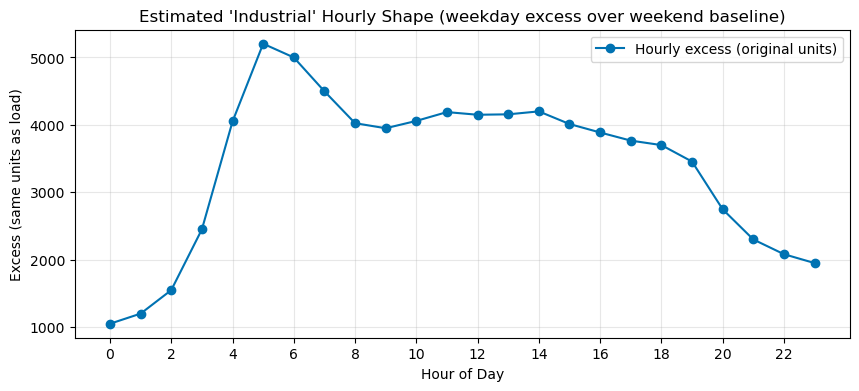

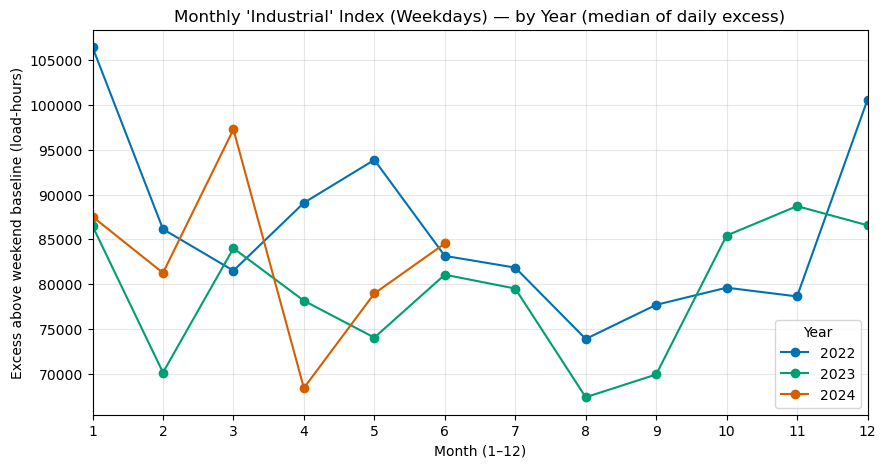

In [56]:
# (P1) Hourly shape (median excess by hour) — original and normalized for reference
plt.figure(figsize=(10,4))
plt.plot(I_hour.index, I_hour.values, marker="o", label="Hourly excess (original units)")
plt.title("Estimated 'Industrial' Hourly Shape (weekday excess over weekend baseline)")
plt.xlabel("Hour of Day")
plt.ylabel("Excess (same units as load)")
plt.xticks(range(0,24,2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# (P2) Monthly industrial index (median of daily excess), three curves by year
plt.figure(figsize=(10,5))
for y in sorted(mm_idx["year"].unique()):
    sub = mm_idx.loc[mm_idx["year"] == y]
    plt.plot(sub["month"], sub["industrial_index"], marker="o", linestyle="-", label=str(y))
plt.title("Monthly 'Industrial' Index (Weekdays) — by Year (median of daily excess)")
plt.xlabel("Month (1–12)")
plt.ylabel("Excess above weekend baseline (load-hours)")
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.legend(title="Year")
plt.show()

### Report Metrics

In [57]:
yearly_metrics = (
    monthly_metrics
    .assign(year=monthly_metrics["month_start"].dt.year)
    .groupby("year", as_index=False)
    .agg({
        "peak_load_weekday": "mean",
        "peak_hour_weekday": "mean",
        "night_min_weekday": "mean",
        "morning_ramp_0408_weekday": "mean",
        "evening_minus_midday_weekday": "mean",
        "weekend_weekday_gap_at_06": "mean"
    })
)

monthly_metrics_rounded = monthly_metrics.drop(columns=["month_period"]).copy()
yearly_metrics_rounded = yearly_metrics.copy()

to_round = [
    "peak_load_weekday",
    "peak_hour_weekday",
    "night_min_weekday",
    "morning_ramp_0408_weekday",
    "evening_minus_midday_weekday",
    "weekend_weekday_gap_at_06"
]
monthly_metrics_rounded[to_round] = monthly_metrics_rounded[to_round].round(3)
yearly_metrics_rounded[to_round] = yearly_metrics_rounded[to_round].round(3)

monthly_metrics_rounded.to_csv("monthly_load_profile_metrics.csv", index=False)
yearly_metrics_rounded.to_csv("yearly_load_profile_metrics.csv", index=False)

KeyError: "Column(s) ['evening_minus_midday_weekday', 'morning_ramp_0408_weekday', 'night_min_weekday', 'peak_hour_weekday', 'peak_load_weekday', 'weekend_weekday_gap_at_06'] do not exist"